# Session 5: Realized Volatility and High-Frequency Data

## Course: Advanced Volatility Modeling

---

## Learning Objectives

By the end of this session, students will be able to:
1. Understand the theory of quadratic variation and realized volatility
2. Compute realized variance and its variants from high-frequency data
3. Address market microstructure noise
4. Implement kernel-based and subsampling estimators

---

## 1. From Latent to Observable Volatility

### 1.1 The Problem with GARCH

In GARCH models, volatility $\sigma_t$ is **latent** (unobserved). With intraday data, we can **measure** volatility more precisely using **Realized Volatility (RV)**.

### 1.2 Continuous-Time Framework

Assume log-prices follow a diffusion:

$$dp_t = \mu_t dt + \sigma_t dW_t$$

The **integrated variance** over day $t$ is:

$$IV_t = \int_0^1 \sigma_s^2 ds$$

## 2. Quadratic Variation and Realized Variance

### 2.1 Realized Variance

$$\boxed{RV_t = \sum_{i=1}^{M} r_{t,i}^2}$$

**Theorem**: $RV_t \xrightarrow{p} IV_t$ as $M \to \infty$

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

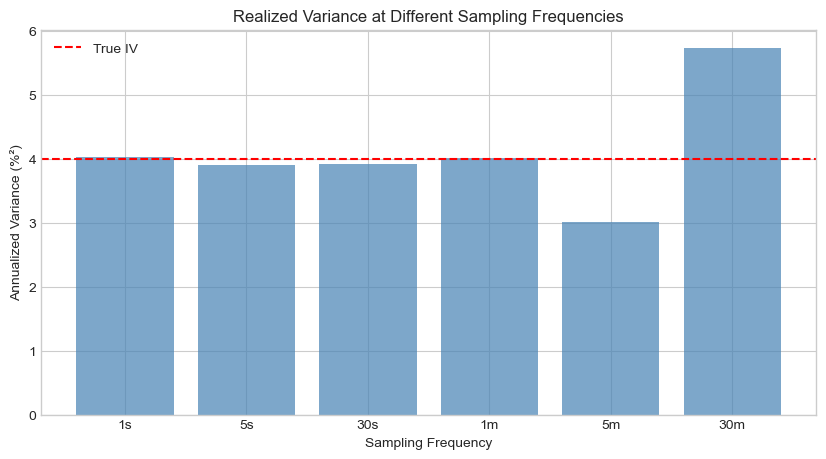

In [5]:
def simulate_diffusion(T, n_steps, mu=0.05, sigma=0.2, seed=None):
    """Simulate geometric Brownian motion."""
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / n_steps
    t = np.linspace(0, T, n_steps + 1)
    dW = np.random.standard_normal(n_steps) * np.sqrt(dt)
    
    log_prices = np.zeros(n_steps + 1)
    for i in range(n_steps):
        log_prices[i+1] = log_prices[i] + (mu - 0.5*sigma**2)*dt + sigma*dW[i]
    
    return t, log_prices, sigma**2 * T

def compute_rv(log_prices, sampling_freq):
    """Compute realized variance."""
    sampled = log_prices[::sampling_freq]
    returns = np.diff(sampled)
    return np.sum(returns**2)

# Simulate one day
T = 1/252
n_steps = 23400  # 1-second frequency
sigma_true = 0.20

t, log_prices, true_iv = simulate_diffusion(T, n_steps, sigma=sigma_true, seed=42)

# RV at different frequencies
freqs = [1, 5, 30, 60, 300, 1800]
labels = ['1s', '5s', '30s', '1m', '5m', '30m']
rvs = [compute_rv(log_prices, f) for f in freqs]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(len(rvs)), [rv * 252 * 100 for rv in rvs], color='steelblue', alpha=0.7)
ax.axhline(true_iv * 252 * 100, color='red', linestyle='--', label=f'True IV')
ax.set_xticks(range(len(rvs)))
ax.set_xticklabels(labels)
ax.set_xlabel('Sampling Frequency')
ax.set_ylabel('Annualized Variance (%²)')
ax.set_title('Realized Variance at Different Sampling Frequencies')
ax.legend()
plt.show()

## 3. Market Microstructure Noise

### 3.1 The Problem

Observed prices contain noise from bid-ask bounce, discrete prices, etc.:

$$p_t^{obs} = p_t^{*} + \eta_t$$

where $\eta_t$ is microstructure noise (often i.i.d. with $E[\eta] = 0$, $\text{Var}(\eta) = \omega^2$).

### 3.2 Impact on RV

With noise, as $M \to \infty$:

$$RV_t \to IV_t + 2M\omega^2$$

RV **explodes** at high frequencies due to noise!

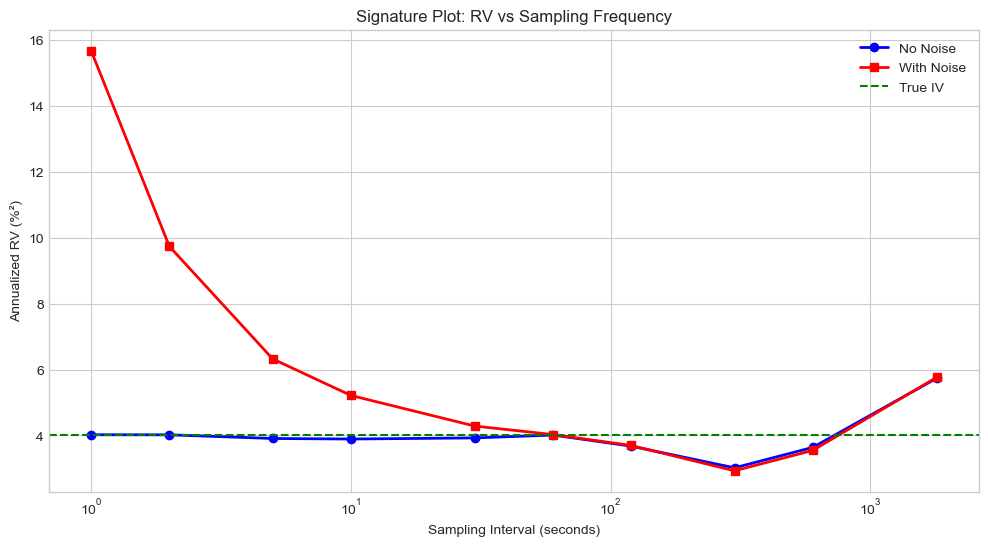


The 'signature plot' shows RV exploding at high frequencies due to noise.
Optimal sampling: 5-minute returns (300 seconds) is a common compromise.


In [9]:
def add_microstructure_noise(log_prices, noise_std):
    """Add i.i.d. microstructure noise."""
    noise = np.random.normal(0, noise_std, len(log_prices))
    return log_prices + noise

# Add noise
noise_std = 0.0001  # Typical for liquid stocks
noisy_prices = add_microstructure_noise(log_prices, noise_std)

# Compare RV with and without noise
freqs_extended = [1, 2, 5, 10, 30, 60, 120, 300, 600, 1800]
rv_clean = [compute_rv(log_prices, f) for f in freqs_extended]
rv_noisy = [compute_rv(noisy_prices, f) for f in freqs_extended]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(freqs_extended, [rv * 252 * 100 for rv in rv_clean], 'b-o', label='No Noise', linewidth=2)
ax.plot(freqs_extended, [rv * 252 * 100 for rv in rv_noisy], 'r-s', label='With Noise', linewidth=2)
ax.axhline(true_iv * 252 * 100, color='green', linestyle='--', label='True IV')
ax.set_xscale('log')
ax.set_xlabel('Sampling Interval (seconds)')
ax.set_ylabel('Annualized RV (%²)')
ax.set_title('Signature Plot: RV vs Sampling Frequency')
ax.legend()
plt.show()

print("\nThe 'signature plot' shows RV exploding at high frequencies due to noise.")
print("Optimal sampling: 5-minute returns (300 seconds) is a common compromise.")

## 4. Noise-Robust Estimators

### 4.1 Two-Scale Realized Variance (Zhang et al., 2005)

$$TSRV = \frac{1}{K}\sum_{k=1}^{K} RV^{(k)} - \frac{\bar{n}}{n} RV^{(all)}$$

### 4.2 Realized Kernel (Barndorff-Nielsen et al., 2008)

$$RK = \sum_{h=-H}^{H} k\left(\frac{h}{H}\right) \hat{\gamma}_h$$

where $\hat{\gamma}_h$ is the autocovariance of returns at lag $h$.

In [12]:
def two_scale_rv(log_prices, K=5):
    """Two-Scale Realized Variance estimator."""
    n = len(log_prices) - 1
    
    # Slow scale: average of K subsamples
    rv_slow = 0
    for k in range(K):
        subsample = log_prices[k::K]
        returns = np.diff(subsample)
        rv_slow += np.sum(returns**2)
    rv_slow /= K
    
    # Fast scale: all returns
    returns_all = np.diff(log_prices)
    rv_fast = np.sum(returns_all**2)
    
    # Bias correction
    n_bar = (n - K + 1) / K
    tsrv = rv_slow - (n_bar / n) * rv_fast
    
    return max(tsrv, 0)

def realized_kernel(log_prices, H=None, kernel='parzen'):
    """Realized Kernel estimator."""
    returns = np.diff(log_prices)
    n = len(returns)
    
    if H is None:
        H = int(4 * (n/100)**(2/5))
    
    def parzen_kernel(x):
        x = np.abs(x)
        if x <= 0.5:
            return 1 - 6*x**2 + 6*x**3
        elif x <= 1:
            return 2*(1-x)**3
        return 0
    
    # Compute autocovariances
    gamma_0 = np.sum(returns**2)
    rk = gamma_0
    
    for h in range(1, H+1):
        gamma_h = np.sum(returns[h:] * returns[:-h])
        weight = parzen_kernel(h / H)
        rk += 2 * weight * gamma_h
    
    return max(rk, 0)

# Compare estimators
tsrv = two_scale_rv(noisy_prices, K=5)
rk = realized_kernel(noisy_prices)
rv_5min = compute_rv(noisy_prices, 300)

print("Comparison of RV Estimators (with microstructure noise)")
print("="*60)
print(f"True IV (ann.):           {true_iv * 252 * 100:.4f}%²")
print(f"RV 5-minute (ann.):       {rv_5min * 252 * 100:.4f}%²")
print(f"Two-Scale RV (ann.):      {tsrv * 252 * 100:.4f}%²")
print(f"Realized Kernel (ann.):   {rk * 252 * 100:.4f}%²")

Comparison of RV Estimators (with microstructure noise)
True IV (ann.):           4.0000%²
RV 5-minute (ann.):       2.9295%²
Two-Scale RV (ann.):      3.0385%²
Realized Kernel (ann.):   3.7773%²


## 5. Jump-Robust Measures

### 5.1 Bipower Variation

$$BV_t = \mu_1^{-2} \sum_{i=2}^{M} |r_{t,i}| |r_{t,i-1}|$$

where $\mu_1 = \sqrt{2/\pi} \approx 0.7979$. Under no jumps: $BV_t \xrightarrow{p} IV_t$.

### 5.2 Jump Detection

$$RV_t - BV_t \xrightarrow{p} \sum_j \kappa_j^2$$

where $\kappa_j$ are jump sizes.

In [15]:
def bipower_variation(log_prices, sampling_freq=1):
    """Compute bipower variation."""
    sampled = log_prices[::sampling_freq]
    returns = np.diff(sampled)
    mu1 = np.sqrt(2/np.pi)
    bv = (1/mu1**2) * np.sum(np.abs(returns[1:]) * np.abs(returns[:-1]))
    return bv

def simulate_jump_diffusion(T, n_steps, sigma=0.2, jump_intensity=1, jump_std=0.02, seed=None):
    """Simulate jump-diffusion process."""
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / n_steps
    log_prices = np.zeros(n_steps + 1)
    
    for i in range(n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        dN = np.random.poisson(jump_intensity * dt)
        jump = np.sum(np.random.normal(0, jump_std, dN)) if dN > 0 else 0
        log_prices[i+1] = log_prices[i] + sigma * dW + jump
    
    return log_prices

# Simulate with jumps
log_prices_jump = simulate_jump_diffusion(T, n_steps, sigma=sigma_true, 
                                          jump_intensity=5, jump_std=0.005, seed=42)

rv_jump = compute_rv(log_prices_jump, 300)
bv_jump = bipower_variation(log_prices_jump, 300)
jump_component = max(rv_jump - bv_jump, 0)

print("Jump Detection using Bipower Variation")
print("="*50)
print(f"RV (5-min):          {rv_jump * 252 * 100:.4f}%² (ann.)")
print(f"BV (5-min):          {bv_jump * 252 * 100:.4f}%² (ann.)")
print(f"Jump Component:      {jump_component * 252 * 100:.4f}%² (ann.)")
print(f"Jump Share:          {100 * jump_component / rv_jump:.1f}%")

Jump Detection using Bipower Variation
RV (5-min):          4.1741%² (ann.)
BV (5-min):          3.8990%² (ann.)
Jump Component:      0.2751%² (ann.)
Jump Share:          6.6%


## 6. Realized Measures: Summary

| Measure | Formula | Properties |
|---------|---------|------------|
| RV | $\sum r_i^2$ | Simple, sensitive to noise and jumps |
| BV | $\mu_1^{-2} \sum |r_i||r_{i-1}|$ | Jump-robust |
| TSRV | Subsampling + bias correction | Noise-robust |
| RK | Kernel-weighted autocovariances | Noise-robust |

## 7. Summary

### Key Takeaways

1. **Realized Variance** provides a direct measure of volatility from high-frequency data
2. **Microstructure noise** causes RV to explode at ultra-high frequencies
3. **Signature plots** help identify optimal sampling frequency
4. **Noise-robust estimators** (TSRV, RK) enable use of higher frequencies
5. **Bipower variation** is robust to jumps

### Preview: Session 6
HAR models for forecasting realized volatility.

## Exercises

1. Implement the **median realized variance** (MedRV) and compare to BV for jump robustness
2. Create signature plots for different noise levels
3. Implement the **pre-averaging** estimator of Jacod et al. (2009)
4. Test jump detection using the ratio statistic $RV/BV$

## References

1. Andersen, T. G., Bollerslev, T., Diebold, F. X., & Labys, P. (2001). The distribution of realized exchange rate volatility. *JASA*, 96(453), 42-55.
2. Barndorff-Nielsen, O. E., & Shephard, N. (2004). Power and bipower variation. *Econometrica*, 72(5), 1481-1517.
3. Zhang, L., Mykland, P. A., & Aït-Sahalia, Y. (2005). A tale of two time scales. *JASA*, 100(472), 1394-1411.